In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def getData(filePathWithName):
    
    return pd.read_csv(filePathWithName)

In [3]:
def getPreprocessedData(df):
    
    columnNameUniqueValueCountMap = {}
    
    for element in df.dtypes.iteritems():
        
        if(element[0] != 'date_time'):
            if element[1].name == 'object':
            
                columnNameUniqueValueCountMap[element[0]] = df[element[0]].unique()
            else:
                columnNameUniqueValueCountMap[element[0]] = 0
        else:
            timeList = []
            for index in range(0,24):
                timeList.append(index)
            columnNameUniqueValueCountMap['time'] = timeList
    
    preprocessedDataList = []
    
    columnNameList = []
    
    for key,value in columnNameUniqueValueCountMap.items():

        if(isinstance(value,np.ndarray)):
            
            for columnName in value:
                columnNameList.append(key+'_'+columnName)
        elif isinstance(value,list):
            for columnName in value:
                columnNameList.append(key+'_'+str(columnName))
        else:
            columnNameList.append(key)
        
    for row in df.iterrows():
        listData = []
        for item in row[1].iteritems():

            if item[0] in columnNameUniqueValueCountMap \
                and isinstance(columnNameUniqueValueCountMap[item[0]],np.ndarray) \
                and len(columnNameUniqueValueCountMap[item[0]]) > 0:
                
                uniqueValues = columnNameUniqueValueCountMap[item[0]]
                for value in uniqueValues:
                    
                    if value == item[1]:
                        listData.append(1)
                    else:
                        listData.append(0)
            elif item[0] in columnNameUniqueValueCountMap \
                and not isinstance(columnNameUniqueValueCountMap[item[0]],np.ndarray):
                
                listData.append(item[1])
            else:
                uniqueValues = columnNameUniqueValueCountMap['time']
                for value in uniqueValues:
                    dateTimeObj = datetime.datetime.strptime(item[1], '%Y-%m-%d %H:%M:%S')
                    if value == dateTimeObj.hour:
                        listData.append(1)
                    else:
                        listData.append(0)
                    
        preprocessedDataList.append(listData)
        
    preprocessedDataFrame = pd.DataFrame(preprocessedDataList)
    preprocessedDataFrame.columns = columnNameList
    return preprocessedDataFrame

In [4]:
def performRegression(dataFrame):

    c = [0.1, 0.01, 0.05, 0.02, 1]
    bestWRR = []
    RMSE = []
    trainFrame = dataFrame.iloc[:,17:90]

    responseFrame = dataFrame.iloc[:,-1]
    trainFrame = trainFrame.iloc[:,:-1]
    xxT = np.dot(trainFrame.transpose(), trainFrame)
    for i in c:
        wRR = 0.0
        cIdentity = (1/(2*i))*np.identity(trainFrame.shape[1])
        inverse = np.linalg.inv(xxT + cIdentity)
        xY = (np.dot(trainFrame.transpose(),responseFrame))
        wRR = np.dot(inverse,xY)
        bestWRR.append(wRR)
        A = xxT + cIdentity
        AInv = np.linalg.inv(A)
        sumRmse = 0.0
        for valIndex in range(len(dataFrame)):
            numerator = (np.dot(dataFrame.iloc[valIndex,17:89],wRR)) - dataFrame.iloc[valIndex,90]
            denominator = (1-(np.dot(np.dot(dataFrame.iloc[valIndex,17:89],AInv),dataFrame.iloc[valIndex,17:89].transpose())))
            sumRmse += math.pow((numerator/denominator),2)
        RMSE.append(math.sqrt(sumRmse/len(dataFrame)))
    print("RMSE",RMSE)
    return bestWRR

In [5]:
def predict(wRR, testSet):
    
    return np.dot(testSet.iloc[:,17:89],wRR)

In [6]:
if os.path.exists('./data/preprocessedData.csv'):
    preprocessedData = getData("./data/preprocessedData.csv")
else:
    df = getData("./data/Metro_Interstate_Traffic_Volume.csv")
    preprocessedData = getPreprocessedData(df)
    preprocessedData.to_csv('./data/preprocessedData.csv', sep=',')

In [7]:
preprocessedData.head()

,Unnamed: 0,holiday_None,holiday_Columbus Day,holiday_Veterans Day,holiday_Thanksgiving Day,holiday_Christmas Day,holiday_New Years Day,holiday_Washingtons Birthday,holiday_Memorial Day,holiday_Independence Day,...,time_15,time_16,time_17,time_18,time_19,time_20,time_21,time_22,time_23,traffic_volume
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5545
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4516
2,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4767
3,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5026
4,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4918


In [8]:
trainingSet, testSet = train_test_split(preprocessedData, test_size=0.05, shuffle=False)
wRR = performRegression(trainingSet)

RMSE [947.0064084140643, 954.4462545830494, 947.4365968981006, 949.6713294019498, 947.0137122978796]


[ 760.9982969  2037.98773652 2074.20286117 ... 2565.97234996 2235.45802785
 1583.66118672]


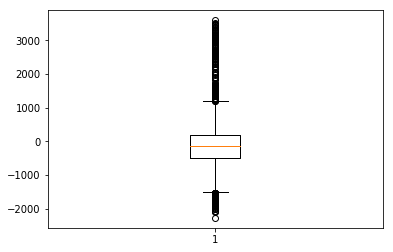

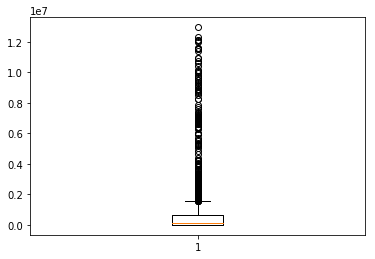

[ 760.9982969  2037.98773652 2074.20286117 ... 2565.97234996 2235.45802785
 1583.66118672]


In [9]:
predictionVector = predict(wRR[0], testSet)
print(predictionVector)
d1 = (predictionVector - testSet.iloc[:,-1])
d2 = np.power(d1,2)
plt.boxplot(d1)
plt.show()
plt.boxplot(d2)
plt.show()
print(predictionVector)